---
title: py4DSTEM Parallax Reconstruction Notebook
authors: [Georgios Varnavides]
date: 2024/07/22
---

### Imports

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import py4DSTEM

import ipywidgets
from IPython.display import display

style = {'description_width': 'initial'}

### Load Data

In [2]:
file_path = 'data/'
file_data_01 = file_path + 'parallax_apoferritin_simulation_100eA2_01.h5'
file_data_02 = file_path + 'parallax_apoferritin_simulation_100eA2_02.h5'

dataset_01 = py4DSTEM.read(file_data_01)
dataset_02 = py4DSTEM.read(file_data_02)
dataset = py4DSTEM.DataCube(np.hstack((dataset_01.data,dataset_02.data)),calibration=dataset_01.calibration)
dataset

DataCube( A 4-dimensional array of shape (24, 48, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

### py4DSTEM Reconstruct

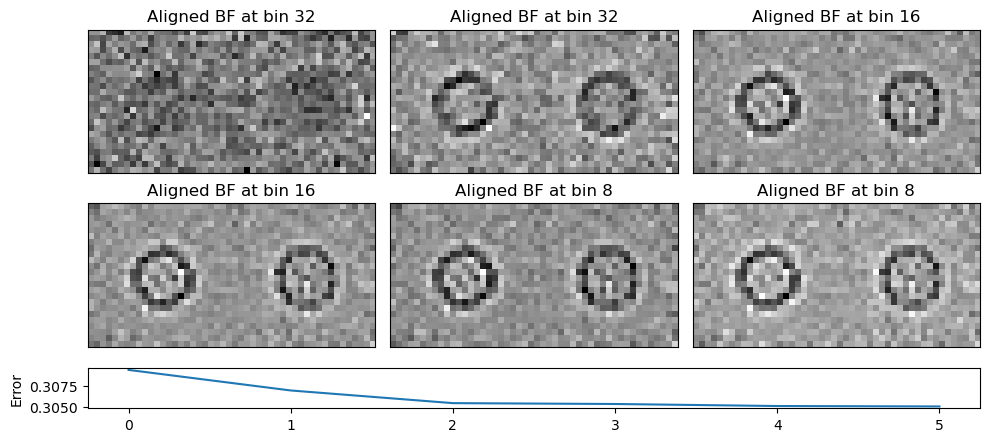

In [3]:
#| label: app:py4dstem_parallax_reconstruct

with plt.ioff():
    parallax = py4DSTEM.process.phase.Parallax(
        datacube=dataset,
        energy = 300e3,
        object_padding_px=(8,8),
    ).preprocess(
        edge_blend=4,
        plot_average_bf=False,
    ).reconstruct(
        alignment_bin_values=[32,32,16,16,8,8],
        progress_bar=False,
        figsize=(10,4.5),
        cmap='gray',
    )
    fig_reconstruct = plt.gcf()
fig_reconstruct

### Measured Cross Corellation Shifts

In [8]:
def return_plot_ind(
    gpts=parallax._region_of_interest_shape,
    dp_mask=parallax._dp_mask,
    plot_arrow_freq=1
):
    """ """
    dp_mask_ind = np.nonzero(dp_mask)
    xx, yy = np.meshgrid(np.arange(gpts[0]),np.arange(gpts[1]),indexing='ij')
    freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
    masked_ind = np.logical_and(freq_mask, dp_mask)
    plot_ind = masked_ind[dp_mask_ind]
    
    return plot_ind

def return_static_quiver_plot(kxy, uv, plot_ind, ax, color="black", title="predicted bright field shifts"):
    """ """
    
    quiver = ax.quiver(
        kxy[plot_ind, 1],
        kxy[plot_ind, 0],
        uv[plot_ind,1],
        uv[plot_ind,0],
        angles="xy",
        scale_units="xy",
        scale=1,
        color=color
    )
    
    kr_max = np.linalg.norm(kxy,axis=1).max()
    ax.set_xlim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_ylim([-1.2 * kr_max, 1.2 * kr_max])
    ax.set_title(title)
    ax.set_ylabel(r"$k_x$ [$A^{-1}$]")
    ax.set_xlabel(r"$k_y$ [$A^{-1}$]")
    ax.set_aspect("equal")

    return quiver

In [9]:
kxy = parallax._kxy
measured_shifts = parallax._xy_shifts * np.array(parallax._reciprocal_sampling)[None]
plot_ind = return_plot_ind(plot_arrow_freq=4)

dpi=72
with plt.ioff():
    dpi = dpi
    measured_quiver_fig, measured_quiver_ax = plt.subplots(figsize=(350/dpi,350/dpi), dpi=dpi)

measured_quiver = return_static_quiver_plot(
    kxy,
    measured_shifts,
    plot_ind,
    measured_quiver_ax,
    color="red",
    title="measured bright field shifts"
)

measured_quiver_fig.canvas.resizable = False
measured_quiver_fig.canvas.header_visible = False
measured_quiver_fig.canvas.footer_visible = False
measured_quiver_fig.canvas.toolbar_visible = True
measured_quiver_fig.canvas.layout.width = '350px'
measured_quiver_fig.canvas.layout.height = '380px'
measured_quiver_fig.canvas.toolbar_position = 'bottom'
measured_quiver_fig.tight_layout()

def update_measured_quiver(change):
    plot_arrow_freq = change["new"]
    plot_ind = return_plot_ind(plot_arrow_freq=plot_arrow_freq)
    new_shifts = measured_shifts[plot_ind]
    new_kxy = kxy[plot_ind]

    measured_quiver.N = new_kxy.shape[0]
    measured_quiver.XY = np.fliplr(new_kxy)
    measured_quiver.set_offsets(np.fliplr(new_kxy))
    measured_quiver.set_UVC(new_shifts[:,1],new_shifts[:,0])
    
    measured_quiver_fig.canvas.draw_idle()
    return None

arrow_freq_slider_measured = ipywidgets.IntSlider(min=1, max=16, step=1, value=4, style=style, description="plot arrow frequency")
arrow_freq_slider_measured.observe(update_measured_quiver,names='value')

In [10]:
#| label: app:py4dstem_parallax_shifts

display(
    ipywidgets.VBox(
        [
            arrow_freq_slider_measured,
            measured_quiver_fig.canvas
        ],
        layout=ipywidgets.Layout(align_items='center',width='400px'))
)